In [1]:
import shap
import numpy as np
import pandas as pd
import os
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import StandardScaler, RobustScaler
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier as CBC
from sklearn.metrics import confusion_matrix
os.chdir(r'C:\Users\Bruger1\Documents\Data Science\Kandidatspeciale\Preprocessing\Data Description')
df = pd.read_csv('train_df_final.csv')

## Data Prep

In [2]:
#list of categoricals for catboost, convert to integer 
disc_cols = df.columns[(df.apply(lambda x: x.dropna().astype(int) == x.dropna())).all() & (df.max() <= 5000) & (df.min() >= -251)]
cat_cols = disc_cols[(df[disc_cols].nunique() == 2)]
cat_cols = list(cat_cols)
df_cat = df[cat_cols]
df_cat = df_cat.dropna(axis=1, how='any')
df_cat = df_cat.drop(['target'], axis=1)
df_cat = pd.concat([df_cat, df['virksomhedsoplysninger_54']], axis=1)
int_cols = df_cat.dtypes[df_cat.dtypes=='int64'].index
df_cat=df_cat.astype('int64')

#checking 
print(df_cat.dtypes[df_cat.dtypes=='int64'].index)
#simpler way?
#################df_subset=df_subset.astype('int64')

#dropping from original 
df = df.drop(df_cat[df_cat.columns],axis=1)
#carrying a list of the categorical columns 
cat_cols = list(df_cat.columns)

Index(['ejerkreds_aktiv_35', 'ejerkreds_aktiv_39', 'ejerkreds_aktiv_42',
       'ejerkreds_aktiv_45', 'ejerkreds_aktiv_51', 'ejerkreds_aktiv_92',
       'ejerkreds_aktiv_94', 'ejerkreds_aktiv_99', 'ejerkreds_ny_33',
       'ejerkreds_ny_34', 'adresse_1', 'adresse_16', 'risikomarkering_2',
       'risikomarkering_3', 'risikomarkering_5', 'risikomarkering_7',
       'risikomarkering_8', 'risikomarkering_10', 'risikomarkering_11',
       'risikomarkering_12', 'risikomarkering_13', 'risikomarkering_14',
       'risikomarkering_16', 'risikomarkering_17', 'risikomarkering_18',
       'risikomarkering_19', 'risikomarkering_20', 'risikomarkering_21',
       'risikomarkering_23', 'sagsoplysninger_3', 'sagsoplysninger_5',
       'sagsoplysninger_6', 'sagsoplysninger_7', 'sagsoplysninger_9',
       'sagsoplysninger_10', 'sagsoplysninger_11', 'sagsoplysninger_16',
       'sagsoplysninger_17', 'sagsoplysninger_18', 'sagsoplysninger_19',
       'sagsoplysninger_20', 'sagsoplysninger_21', 'sagsoplysn

In [3]:
##################################  Preparing variables for discretization 
# select columns where all the non-NaN values have no decimal places
disc_cols = df.columns[(df.apply(lambda x: x.dropna().astype(int) == x.dropna())).all() & (df.max() <= 5000) & (df.min() >= -251)]
# convert the lists to sets and take the set difference

disc_cols = disc_cols[~(df[disc_cols].nunique() == 2)]
disc_cols = disc_cols[(df[disc_cols].nunique() >4)]
disc_cols = list(disc_cols)
vars_to_exclude = ['risikomarkering_count', 'virksomhedsoplysninger_54', 'virksomhedsoplysninger_55']
vars_to_add = ['ejerkreds_aktiv_5']
disc_cols = [col for col in disc_cols if col not in vars_to_exclude] + vars_to_add
df_disc = df[disc_cols]
df_disc = df_disc.dropna(axis=1, how='any')
disc_cols = list(df_disc.columns)

In [4]:
############################ Defining training set splits - 
#adding categoricals back to df 
df = pd.concat([df, df_cat],axis=1)

y_train = df['target']
X_train = df.drop(['target'],axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify = y_train, random_state=41)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, stratify = y_train,  random_state=41)

In [5]:
######### Binnin Variables 
def bin_variables(df, var_list, bins_dict):
    """
    Bins the variables in a DataFrame based on custom bin sizes specified in a dictionary.

    Args:
        df (pandas.DataFrame): The DataFrame containing the variables to be binned.
        bins_dict (dict): A dictionary containing variable names as keys and bin sizes as values.

    Returns:
        pandas.DataFrame: A new DataFrame with the binned variables.
    """
    binned_df = df.copy()
    for var in var_list:
        if var in bins_dict:
            bins = bins_dict[var]
            binned_df[var] = pd.cut(binned_df[var], bins, labels=False, include_lowest=True)
    return binned_df

bins_dict = { ########### cuz trees like categories - univariate splits 
    
             'ejerkreds_aktiv_5': [1, 300, 689, 1192, 1795, 2955],
             'ejerkreds_aktiv_6': [1, 17, 110, 474.5, 4870], 
             'ejerkreds_aktiv_7': [1, 256, 988, 2585, 4882],
             'ejerkreds_aktiv_9': [-319, -6, 0, 3, 187],
             'ejerkreds_aktiv_19': [0, 36.68, 108.67, 315.89, 1599],
             'ejerkreds_aktiv_25': [-27092,-25566, -25559,-25524,-25214],
             'ejerkreds_aktiv_26': [-27420,-25566, -25560,-25527,-25214],
             'ejerkreds_aktiv_83': [0, 1.4, 2, 2.8, 4.8], #time based, however, very small interval 
             
             'virksomhedsoplysninger_14': [-251, 1, 9, 48, 300],
             'virksomhedsoplysninger_15': [-27, 9, 24, 48, 294],
             'virksomhedsoplysninger_16': [-251, 1, 4, 15.5, 240],
             'virksomhedsoplysninger_18': [1, 3, 13, 56, 352],
             'virksomhedsoplysninger_19': [1, 21, 55, 96.5, 272],
             'virksomhedsoplysninger_23': [0, 30.69, 62.94, 134.81, 1540.18],
             'virksomhedsoplysninger_29': [1, 19.75, 27, 44.75, 138],
             'virksomhedsoplysninger_31': [5, 11, 17, 18, 19],
             
             'sagsoplysninger_2': [-361, -20, -5, 0, 251],
   
             'ejerkreds_aktiv_1': [0, 0.5, 1, 77, 294, 2955],
             'ejerkreds_aktiv_2': [0, 0.5, 1, 23], 
             'ejerkreds_aktiv_3': [0, 0.5, 1, 74, 173],
             'ejerkreds_aktiv_4': [0, 0.5, 1, 74, 266],
             'ejerkreds_aktiv_12': [0, 0.5, 1, 44, 92],
             'ejerkreds_aktiv_31': [0, 0.5, 1, 23.73,970, 2381],
             'ejerkreds_aktiv_34': [0, 1, 3, 7],
             'ejerkreds_aktiv_36': [0, 0.5, 1, 3, 8],
             'ejerkreds_aktiv_37': [0, 0.5, 1, 2, 7], 
             'ejerkreds_aktiv_38': [0, 0.5, 1, 3, 14],
             'ejerkreds_aktiv_40': [0, 0.5, 1, 2, 10],
             'ejerkreds_aktiv_41': [0, 0.5, 1, 42, 178],
             'ejerkreds_aktiv_44': [0, 0.5, 1, 14, 81, 112], 
             'ejerkreds_aktiv_46': [0, 0.5, 1, 8, 51],
             'ejerkreds_aktiv_47': [1, 28.5, 244, 858, 2766],
             'ejerkreds_aktiv_48': [1, 9.5, 180, 955],
             'ejerkreds_aktiv_49': [1, 8.95, 177, 917], 
             'ejerkreds_aktiv_50': [0, 1, 10, 177, 985], 
             'ejerkreds_aktiv_75': [0, 1, 56, 77],
             'ejerkreds_aktiv_76': [0, 1, 51, 82],
             'ejerkreds_aktiv_78': [0, 0.5, 1, 2, 7],
             'ejerkreds_aktiv_80': [0, 1, 2, 5],
             'ejerkreds_aktiv_96': [0, 1, 10, 519, 853, 2529],
             'ejerkreds_aktiv_97': [0, 1, 30, 60, 81],
             'ejerkreds_aktiv_102': [0, 1, 2, 8], 
             'ejerkreds_aktiv_126': [0, 1, 2, 44, 92],
             'ejerkreds_aktiv_127': [0, 1, 2, 5],
             'ejerkreds_aktiv_129': [0, 1, 2, 5],
             'ejerkreds_aktiv_130': [0, 1, 13, 21], 
             
             'ejerkreds_ny_8': [0, 1, 2.85, 78, 188, 312],
             'ejerkreds_ny_47': [0, 1, 6, 37],
             'virksomhedsoplysninger_5': [0, 0.5, 1, 2, 18],
             'virksomhedsoplysninger_6': [0, 0.5, 1, 3, 18],
             'virksomhedsoplysninger_17': [0, 1, 1.95, 13, 19],

             'adresse_2':[0, 1.573, 62, 560],
             'adresse_3':[0, 1.423, 60, 560],
             'adresse_4':[0, 1.398, 56, 560],
             'adresse_5':[0, 0.265, 1, 38, 328],
             'adresse_6':[0, 0.03, 1, 2, 8],
             'adresse_7':[0, 0.29, 1, 23, 60],
             'adresse_8':[0, 0.265, 1, 7],
             'adresse_9':[0, 0.016, 1, 3],
             'adresse_10':[0, 0.08, 1, 11, 70],
             'adresse_11':[0, 0.002, 1, 11],
             'adresse_12':[0, 0.008, 1, 2, 8, 57],
             'adresse_13':[0, 0.014, 4],
             'adresse_14':[0, 0.01, 60, 560],
             'adresse_15':[0, 2.5, 56, 560],

             }

X_train = bin_variables(X_train, X_train.columns, bins_dict)
X_test = bin_variables(X_test, X_test.columns, bins_dict)
X_val = bin_variables(X_val, X_val.columns, bins_dict)

In [6]:
X_train_disc = X_train[disc_cols + cat_cols]
X_train = X_train.drop(columns=disc_cols+cat_cols)

X_test_disc = X_test[disc_cols + cat_cols]
X_test = X_test.drop(columns=disc_cols+cat_cols)

X_val_disc = X_val[disc_cols + cat_cols]
X_val = X_val.drop(columns=disc_cols+cat_cols)

#Scaling Data 
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train = pd.concat([X_train, X_train_disc],axis=1)
X_test = pd.concat([X_test, X_test_disc],axis=1)
X_val = pd.concat([X_val, X_val_disc],axis=1)

## Model Initialization, fitting and predicting

In [7]:
class_weight0 = 13719/(2*10335)
class_weight1 = 13719/(2*3384)
class_weights = np.array([class_weight0, class_weight1])

from catboost import Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
#defining Model Architecture
model = CBC(class_weights=class_weights, iterations=138, cat_features=cat_cols, learning_rate=0.10005057882519877, od_type="Iter", od_wait=100, random_state = 42000,
            max_depth=16, colsample_bylevel=0.5, subsample=0.7753, bagging_temperature=0.0,
            random_strength=1, one_hot_max_size=25, reg_lambda=36.966)
cat_model = model.fit(train_pool)
y_hat = model.predict(val_pool)

print(classification_report(y_val, y_hat))

0:	learn: 0.6744324	total: 2.62s	remaining: 5m 58s
1:	learn: 0.6550153	total: 2.71s	remaining: 3m 3s
2:	learn: 0.6393266	total: 5.23s	remaining: 3m 55s
3:	learn: 0.6262621	total: 7.84s	remaining: 4m 22s
4:	learn: 0.6146753	total: 10.3s	remaining: 4m 34s
5:	learn: 0.6034233	total: 13.1s	remaining: 4m 47s
6:	learn: 0.5935561	total: 15.7s	remaining: 4m 53s
7:	learn: 0.5852312	total: 18.4s	remaining: 4m 58s
8:	learn: 0.5779839	total: 20.9s	remaining: 4m 59s
9:	learn: 0.5701673	total: 23.5s	remaining: 5m
10:	learn: 0.5623619	total: 26.4s	remaining: 5m 4s
11:	learn: 0.5561015	total: 29s	remaining: 5m 4s
12:	learn: 0.5488209	total: 31.8s	remaining: 5m 5s
13:	learn: 0.5434548	total: 34.7s	remaining: 5m 7s
14:	learn: 0.5377310	total: 37.2s	remaining: 5m 5s
15:	learn: 0.5316585	total: 39.8s	remaining: 5m 3s
16:	learn: 0.5276563	total: 42.4s	remaining: 5m 1s
17:	learn: 0.5230220	total: 44.8s	remaining: 4m 58s
18:	learn: 0.5191296	total: 47.2s	remaining: 4m 55s
19:	learn: 0.5156800	total: 49.9s	re

Good Tax Payer Detected (True Negatives):  1246
Good Tax Payer Incorrectly Detected as Fraud (False Positives):  304
Fraudulent Tax Payer Not Detected (False Negatives):  172
Fraudulent Tax Payer Detected (True Positives):  336
Total Companies Deemed Fraudulent:  508


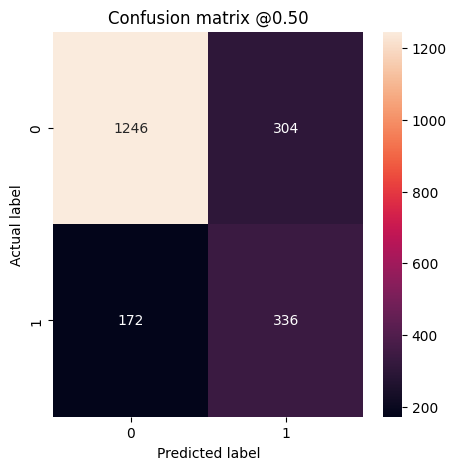

In [8]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Good Tax Payer Detected (True Negatives): ', cm[0][0])
  print('Good Tax Payer Incorrectly Detected as Fraud (False Positives): ', cm[0][1])
  print('Fraudulent Tax Payer Not Detected (False Negatives): ', cm[1][0])
  print('Fraudulent Tax Payer Detected (True Positives): ', cm[1][1])
  print('Total Companies Deemed Fraudulent: ', np.sum(cm[1]))
  
plot_cm(y_val, y_hat)

Not the best performance, but in line with previous models. Guess it is also a rather difficult classification task. 

Explainer expected value: 0.02535466797831843


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


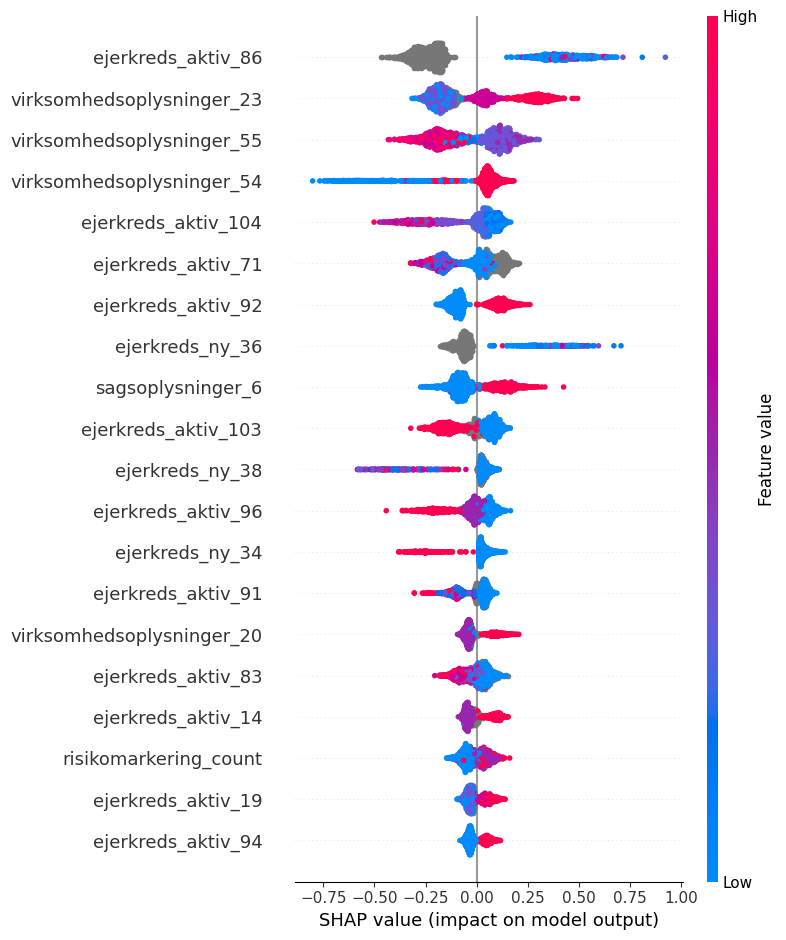

In [9]:
import warnings
explainer =  shap.Explainer(model, feature_names=X_val.columns)  #shap.TreeExplainer(Cat_model)
shap_values = explainer(val_pool)

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

shap.summary_plot(shap_values, features=X_val)

Almost all Catboost models I ran on this dataset, selected ejerkreds_aktiv_86 as the number 1 or top 3 most significant features in terms of the magnitude of impact it has on the model predictions. Same goes for variables like ejerkreds_aktiv_71 and virksomhedsoplysninger_54+55+23. 

Can we consider the model competent in its ability to evaluate what is truly important for the task? The confusion matrices does reveal somewhat competence in terms of the negative class, but not really so for the positive class. So, to build on our analysis, we want to extract some confidence estimates.

Ideally, we would traverse the Catboost model architecture, calculate the gini impurities of the leaf nodes, and then extract the associated feature splits that leads to the purest nodes. CatBoost does not provide scikit-like functionality, that more easily enables one to do this.

So, i propose a compromise. We use the few functionalities catboost does provide: calculate_leaf_indexes, this returns the exact leaf node each prediction i ends up in, after j-th iteration. Hence, we can access the final leaf node, calculate the class distribution and then calculate the gini impurities for the final leaf nodes. A compromise to extracting the exact feature splits in the tree of the pure nodes, then, is to use SHAP decision plots to see which features had the most impact on the most pure nodes, as given by our calculation of gini impurities. This should help us identify which features are associated with the highest quality decision rules. 

In [118]:
#resetting indexes - easier to use for SHAP Decision plots 
y_val = y_val.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [11]:
################ Gini Impurity and Decision Rules 

# Get predicted class probabilities and leaf node indices for each observation
leaf_indices = model.calc_leaf_indexes(X_val, ntree_start=0, ntree_end=0, thread_count=-1)
class_probs = model.predict_proba(X_val)

# Calculate gini impurity for each leaf node
num_classes = 2
unique_leaf_indices, leaf_counts = np.unique(leaf_indices, return_counts=True)


gini_impurities = np.zeros(len(unique_leaf_indices))
for i, leaf_index in enumerate(unique_leaf_indices):
    # Get the indices of the observations in the leaf node
    leaf_indices_in_node = np.where(np.isin(leaf_indices, leaf_index))[0]
    # Calculate the class distribution in the leaf node
    #class_distribution = np.bincount(y_val[leaf_indices_in_node], minlength=num_classes)
    class_distribution = np.bincount(y_val[leaf_indices_in_node].values, minlength=num_classes)

    # Calculate the gini impurity
    gini_impurity = 1 - np.sum(np.square(class_distribution / np.sum(class_distribution)))
    gini_impurities[i] = gini_impurity

# Create dictionary mapping leaf node index to gini impurity value
leaf_index_to_gini_dict = dict(zip(unique_leaf_indices, gini_impurities))

# Get the index of the final leaf node for each observation
leaf_indices_preds = leaf_indices[:, -1]

# Look up the gini impurity value for each leaf node index in last iteration
gini_impurities_preds = [leaf_index_to_gini_dict[idx] for idx in leaf_indices_preds]

# Add the Gini index to the dataframe of predicted probabilities
class_probs = pd.DataFrame(class_probs, columns=['class_0', 'class_1'])
class_probs['leaf_gini'] = gini_impurities_preds #impurity of the leaf node the prediction belongs to 
class_probs['leaf_indices'] = leaf_indices_preds #index of last leaf per prediction
class_probs['predicted'] = y_hat #predicted class
class_probs['target'] = y_val #true class

In [12]:
class_probs.head()

,class_0,class_1,leaf_gini,leaf_indices,predicted,target
0,0.774455,0.225545,0.367189,35328,0,0
1,0.935020,0.064980,0.375000,656,0,0
2,0.427761,0.572239,0.364185,16384,1,1
3,0.561123,0.438877,0.409403,32768,0,0
4,0.758908,0.241092,0.444444,18520,0,0


We have the model probability estimates, we have the SHAP values for how much each feature contributes to the model decision, and we have our confidence estimate (gini impurity). While at this point, this is not my very best model, it was performing similarly and had the similar feature importances. Plotting the probability estimates of our model, with the gini impurity, reveals a spurious relationship between the certainty the model put in its predictions and the gini impurity

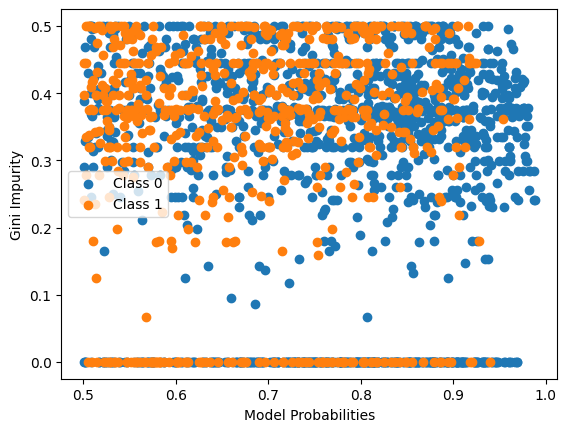

In [14]:
import matplotlib.pyplot as plt

# Select points with predicted probability greater than 0.5 for class 0
class_0_probs = class_probs[class_probs.iloc[:, 0] > 0.5]
class_0_gini = class_0_probs['leaf_gini']

# Select points with predicted probability greater than 0.5 for class 1
class_1_probs = class_probs[class_probs.iloc[:, 1] > 0.5]
class_1_gini = class_1_probs['leaf_gini']

# Create a scatter plot with filtered data
plt.scatter(class_0_probs.iloc[:, 0], class_0_gini, label='Class 0', alpha=1)
plt.scatter(class_1_probs.iloc[:, 1], class_1_gini, label='Class 1', alpha=1)

# Add labels and legend to the plot
plt.xlabel('Model Probabilities')
plt.ylabel('Gini Impurity')
plt.legend()
plt.show()


As we can see above, there is a spurious relationship between high model probability estimates, and our confidence estimate, gini impurity. The lower the gini impurity, the more weight we can put on the importance of features. In general, we can see that the model is usually more confident, places a higher probability, with the negative class.

# SHAP Decision Plots

In [15]:
#We just reuse it again
leaf_indices = model.calc_leaf_indexes(X_val, ntree_start=0, ntree_end=0, thread_count=-1)
leaf_index_to_gini_dict = dict(zip(unique_leaf_indices, gini_impurities))

In [154]:
# Find the minimum impurity value in the leaf_index_to_gini_dict
min_impurity = min(leaf_index_to_gini_dict.values())

# Find the leaf nodes with the minimum impurity value
min_impurity_leaf_indices = [k for k, v in leaf_index_to_gini_dict.items() if v == min_impurity]

#print("Minimum impurity value:", min_impurity)
#print("Leaf indices with minimum impurity:", min_impurity_leaf_indices)


In [134]:
# Get the leaf nodes for the last iteration
leaf_indices_last_iter = leaf_indices[:, -1]

# Compute the impurity values for the last iteration leaves
last_iteration_impurities = [leaf_index_to_gini_dict[node] for node in leaf_indices_last_iter]


# Find the leaf nodes with the 40 lowest impurity values
lowest_impurity_leaves = np.argsort(last_iteration_impurities)[:40]
print(lowest_impurity_leaves)

[1028 1512 1510 1508  559  560 1505  562  565 1500 1499  574  575  579
 1491 1484  552 1515  548 1522  509  513  516  517  518  519  521 1483
  523 1543  529 1542 1535 1531  540  541 1548 1562  589  593]


In [135]:
# subset the dataframe based on the list of indices
subset_df = class_probs.iloc[lowest_impurity_leaves]
# print the subset dataframe
print(subset_df)

       class_0   class_1  leaf_gini  leaf_indices  predicted  target
1028  0.904356  0.095644        0.0         29035          0       0
1512  0.687441  0.312559        0.0         29680          0       0
1510  0.825478  0.174522        0.0           376          0       0
1508  0.522990  0.477010        0.0         25193          0       0
559   0.796401  0.203599        0.0         16745          0       0
560   0.688495  0.311505        0.0         56026          0       0
1505  0.944932  0.055068        0.0         24945          0       0
562   0.679706  0.320294        0.0         34937          0       1
565   0.639944  0.360056        0.0         43120          0       0
1500  0.924151  0.075849        0.0         59497          0       0
1499  0.284580  0.715420        0.0         33393          1       1
574   0.530806  0.469194        0.0         64850          0       0
575   0.534232  0.465768        0.0          4336          0       0
579   0.912184  0.087816        0.

We can see that among 40 random pure leaf nodes, we still have quite few wrong predictions.

In [136]:
#defining the index for the misclassified cases so we can plot them 
mask = (class_probs.index.isin(subset_df.index)) & (class_probs["target"] != class_probs["predicted"])
misclassified = class_probs.loc[mask].index.tolist()
print(misclassified)

[519, 562, 589, 1483, 1543]


In [137]:
#Defining a dataframe for pure leaf nodes in general --- We want to see the feature values when we plot single predictions
sel_pure_leaf_nodes = X_val.index[lowest_impurity_leaf_indices]
print(sel_pure_leaf_nodes)
mask = X_val.index.isin(sel_pure_leaf_nodes)
X_val_filtered = X_val[mask]
print(X_val_filtered.index)

Int64Index([559, 560, 562, 565, 1028, 1500, 1505, 1508, 1510, 1512], dtype='int64')
Int64Index([559, 560, 562, 565, 1028, 1500, 1505, 1508, 1510, 1512], dtype='int64')


In [138]:
#Defining a dataframe for the misclassified observations --- We want to see the feature values when we plot single predictions
sel_misclassified = X_val.index[misclassified]
mask = X_val.index.isin(sel_misclassified)
X_val_misclassified = X_val[mask]
print(X_val_misclassified.index)

Int64Index([519, 562, 589, 1483, 1543], dtype='int64')


## SHAP Decision Plots for Pure Leaf Nodes

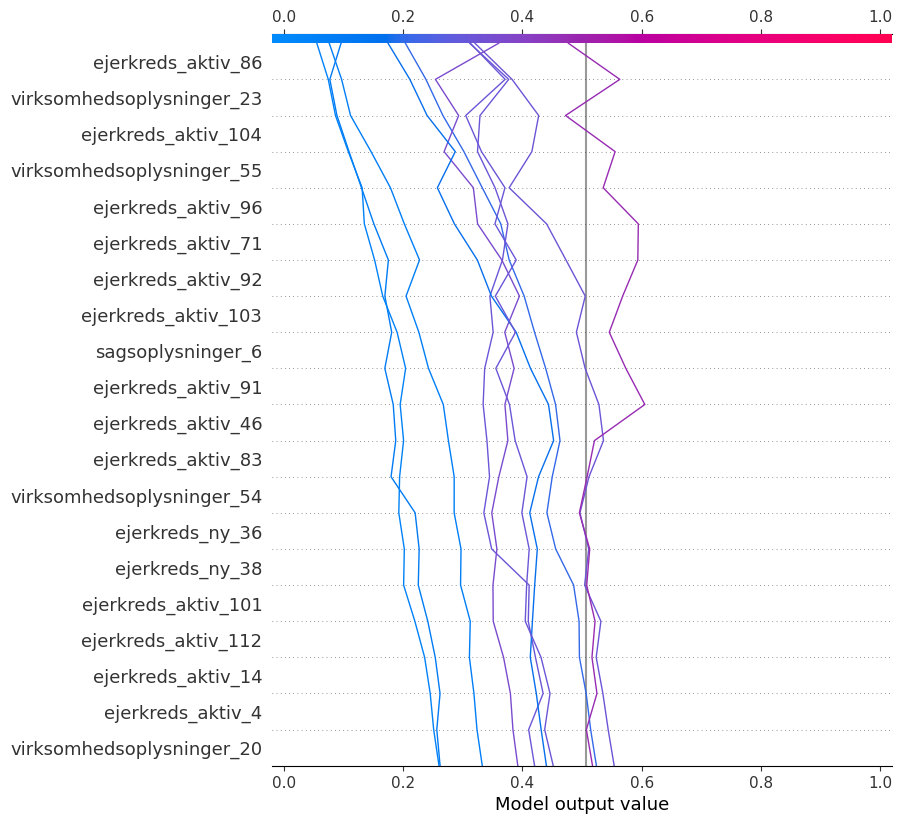

In [128]:
shap.plots.decision(expected_value, explainer.shap_values(X_val_filtered), features=X_val.columns.values, link='logit')

## SHAP Decision Plots: Investigation into wrong predictions in pure leaf nodes

In [ ]:
features = X_val.iloc[lowest_impurity_leaves]
features_display = X_val.loc[features.index]

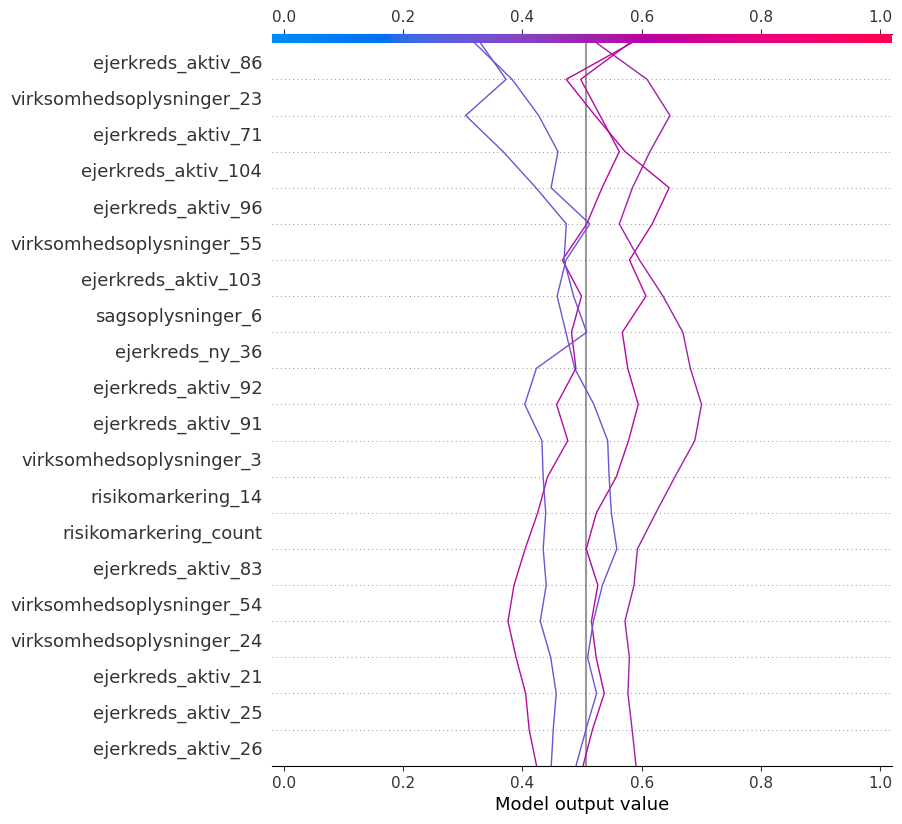

In [139]:
shap.plots.decision(expected_value, explainer.shap_values(X_val_misclassified), features=features_display, link='logit')

Interesting! For the pure leaf nodes, we see that 4 out of 5 cases, variable ejerkreds_aktiv_86 pulls the decision in the wrong direction. Two of the three times we predict class 1 (>0.5), we can see that ejerkreds_aktiv_86 pulls the decision more towards class 1. In the two cases we predict class 0, we also see that ejerkreds_aktiv_86 pulls the decision even more strongly towards class 0. 

In comparison to virksomhedsoplysninger_23 that is deemed second most important by shap values for these 5 cases, in 4 out of 5 cases it actually pulls the prediction towards the correct side of the decision border. It would seem that if it were not for ejerkreds_aktiv_86, two of the predictions would have turned out correct due to virksomhedsoplysninger_23's influence. Alas, ejerkreds_aktiv_86 pushes the model to predict wrongly in the end. 

Investigating further, we can plot each individually, to see the values of the variable for the given prediction.
Please be aware, the order of each feature will change as we consider the average importance for the 5 wrong predictions, to the absolute importance for each observation. 

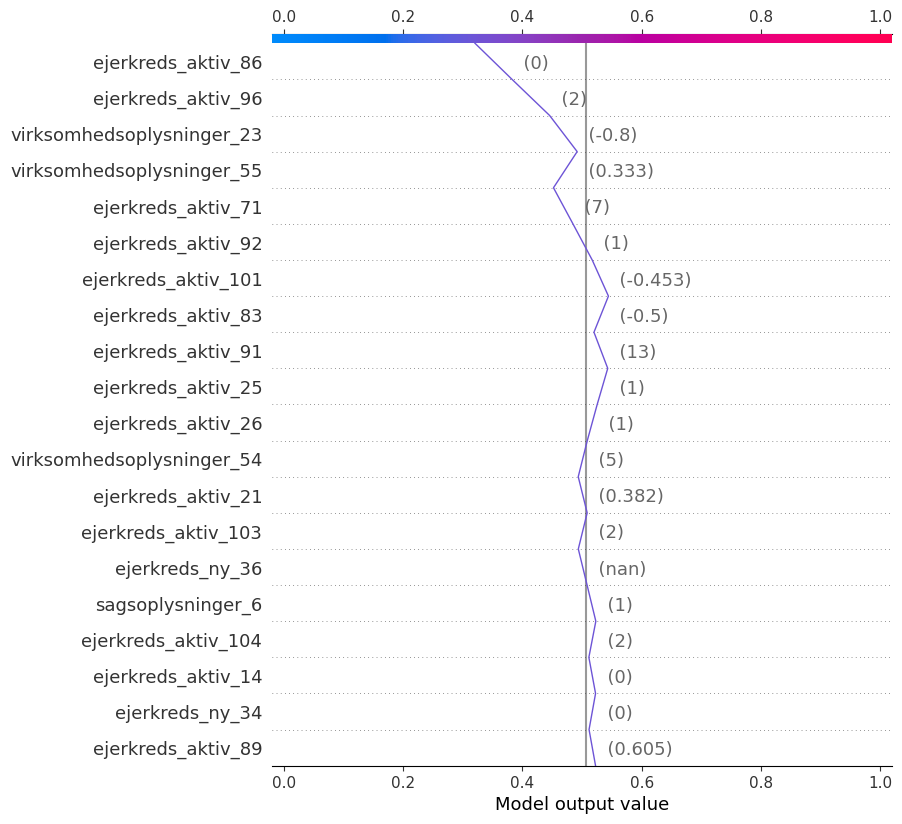

In [133]:
#Plotting first misclassified prediction
shap.plots.decision(expected_value, explainer.shap_values(X_val_misclassified)[0], features=features_display, link='logit')

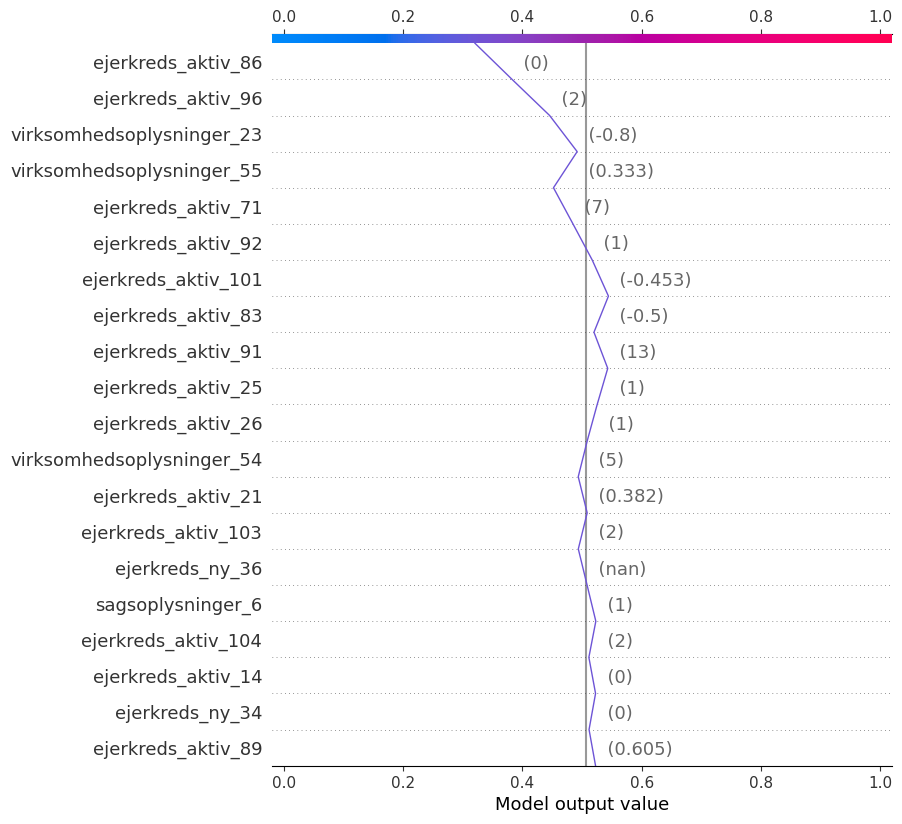

In [140]:
#Plotting second misclassified prediction
shap.plots.decision(expected_value, explainer.shap_values(X_val_misclassified)[1], features=features_display, link='logit')

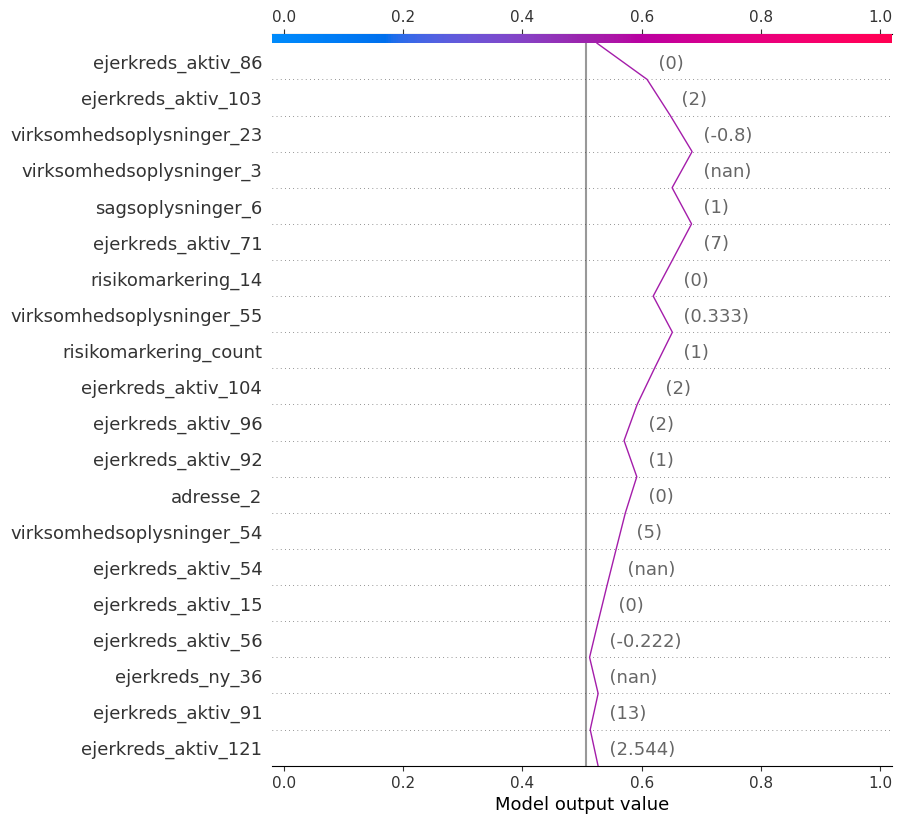

In [141]:
#Plotting third misclassified prediction
shap.plots.decision(expected_value, explainer.shap_values(X_val_misclassified)[2], features=features_display, link='logit')

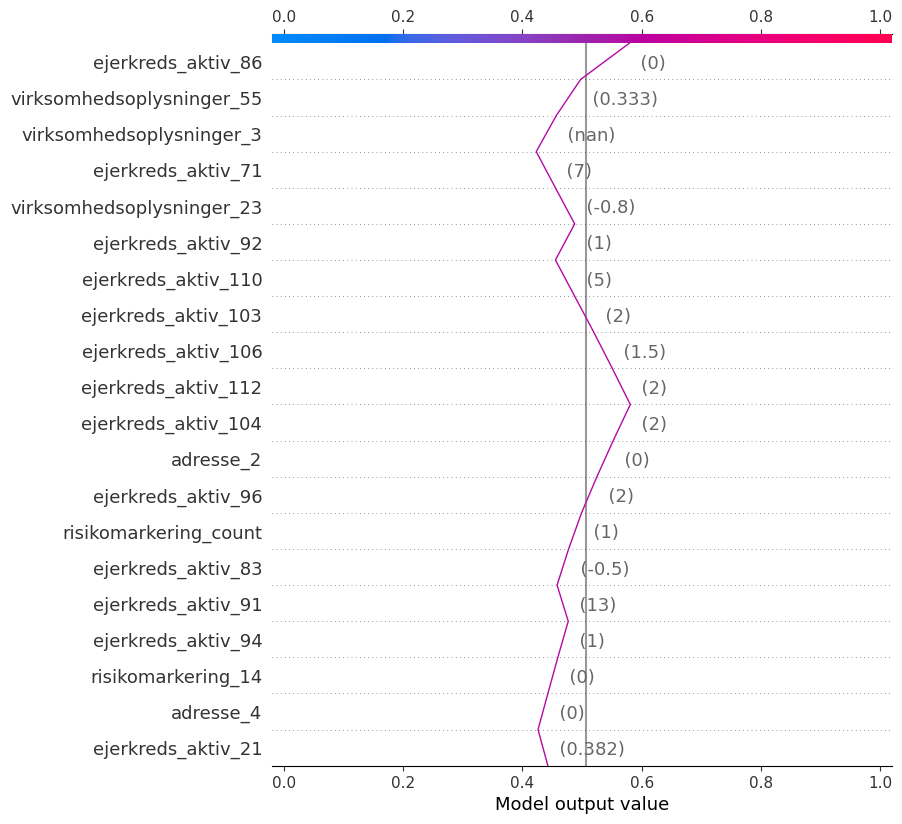

In [142]:
#Plotting fourth misclassified prediction
shap.plots.decision(expected_value, explainer.shap_values(X_val_misclassified)[3], features=features_display, link='logit')

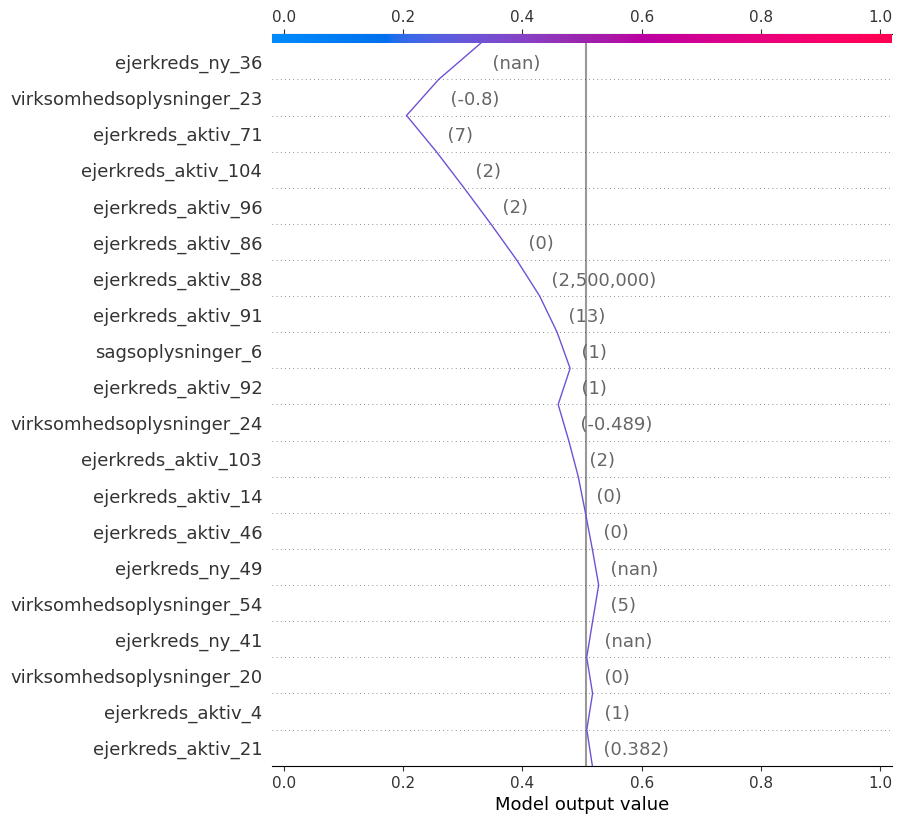

In [144]:
#Plotting fifth misclassified prediction
shap.plots.decision(expected_value, explainer.shap_values(X_val_misclassified)[4], features=features_display, link='logit')

Curious to see what values ejerkreds_aktiv_86 takes for a few random predictions, in the pure leaf nodes

## Plotting individual but random pure leaf nodes 

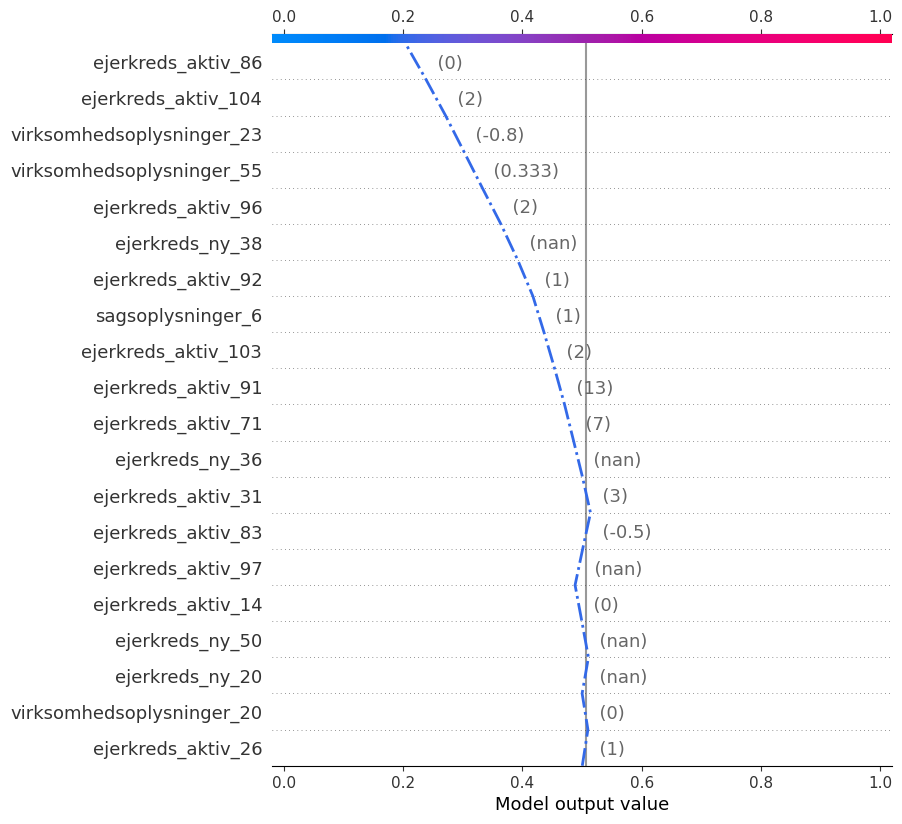

In [99]:
#plot the first of the pure leaf notes
shap.decision_plot(expected_value, explainer.shap_values(X_val_filtered)[0], features_display, link='logit')

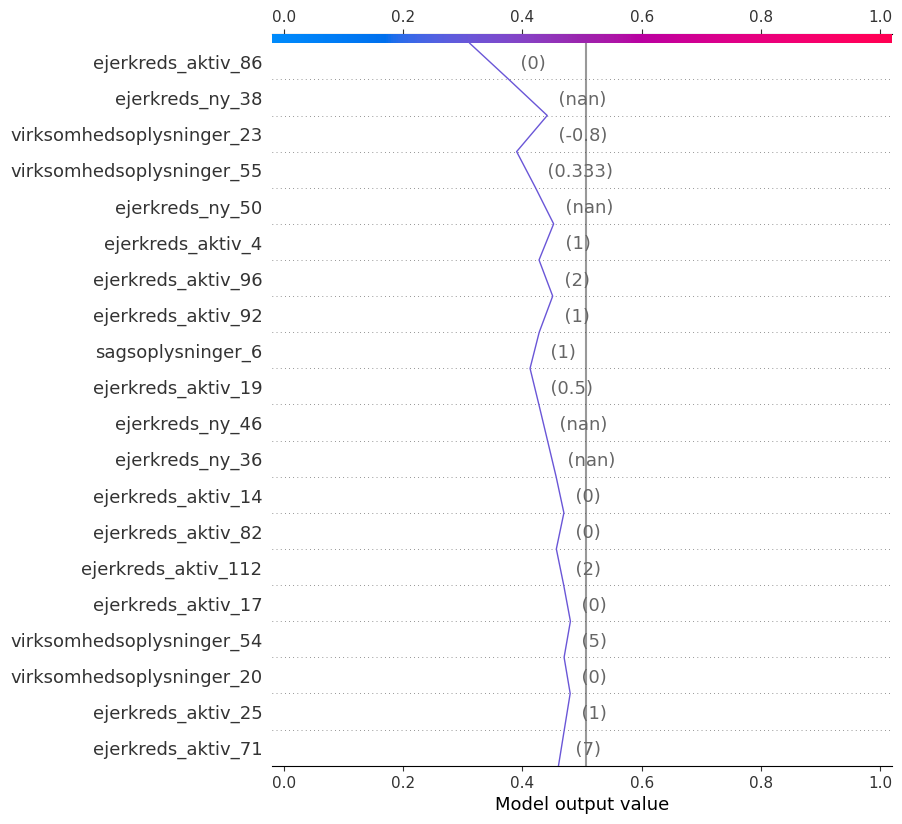

In [152]:
#plot the second of the pure leaf notes
shap.decision_plot(expected_value, explainer.shap_values(X_val_filtered)[1], features_display, link='logit')

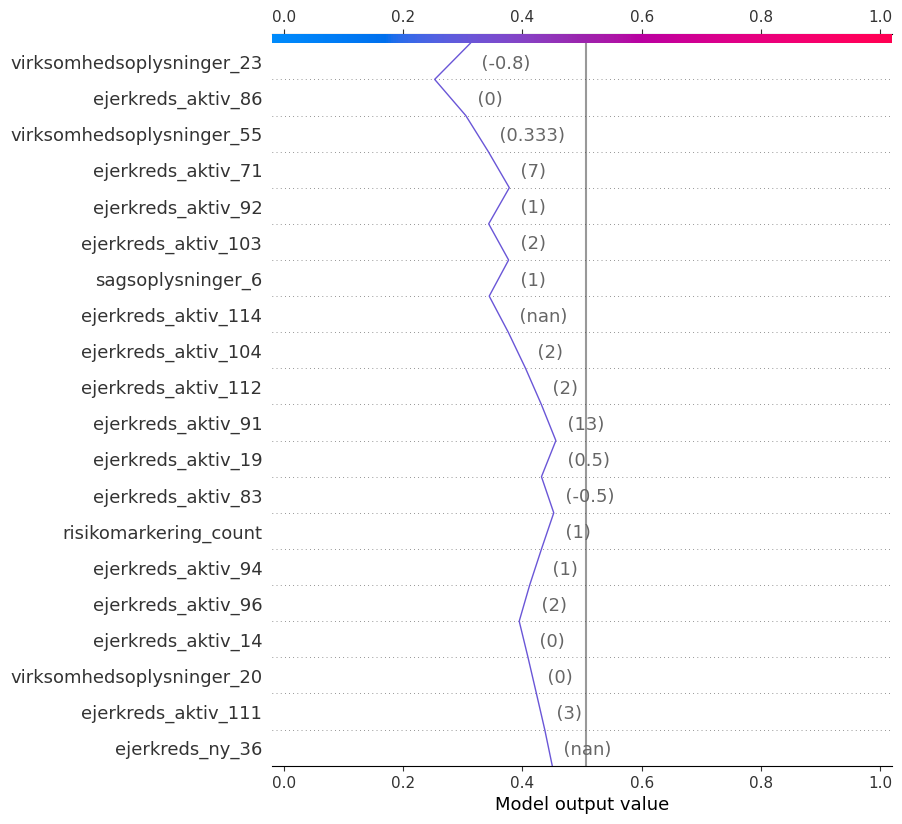

In [153]:
#plot the tenth of the pure leaf notes
shap.decision_plot(expected_value, explainer.shap_values(X_val_filtered)[9], features_display, link='logit')

What is also interesting is that ejerkreds_aktiv_86, in the predictions where leaf nodes are pure, have either only NaN or 0.It seems like it doesnt really contribute to the outcomes if the predictions are correct, and if they are wrong, at least some of the blame can be pointed towards ejerkreds_aktiv_86. This is but a subset of predictions. Further investigation will have to be done, before i reject ejerkreds_aktiv_86 as an important variable. But it could seem like that the model is overfitting to ejerkreds_aktiv_86. 

#### Please note that later application of my favorite feature selection algorithm, Boruta (applied many times with different model architectures) all ended up with the conclusion that ejerkreds_aktiv_86 is most likely useless for the task at hand.  First of all, from the start, I assumed that this would be an important variable to monitor. Though also noting that it might be a confounder rather than a real predictor. Second of all, my first notion was further supported by all CatBoost models returning very high SHAP values for that particular variable. So, the result of the Boruta feature selection algorithm would have been highly confusing to me, if we had not done more thorough analysis, as done above. - I chose to remove ejerkreds_aktiv_86 among many others, which led to a slight increase in performance, and a major decrease in computational complexity. 

If interested in Boruta, see my other repositary for further explanation on how Boruta works (readme file) and for the Borutapy implementation (the ipynb): 
https://github.com/IanWord/DS_Applied_ML_competition_2022